In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
from scipy.optimize import curve_fit
import lmfit as lmf
from scipy.stats import ttest_ind_from_stats as ttest

In [2]:
def myplot(DF,ax=None, color=None, **kwargs):
    m = DF.mean(1).to_numpy()
    s = DF.std(1).to_numpy()
    t = DF.index.values
    if ax:
        ax.plot(t,m, color= color, **kwargs)
        ax.fill_between(t, m-s, m+s, alpha = 0.1, color = color)
    else:
        plt.plot(t,m, color= color, **kwargs)
        plt.fill_between(t, m-s, m+s, alpha = 0.1, color = color)

In [3]:
# Assume Covariance = 0 
# Assume Blank is last index in Endpoint (EP)
# Assume Baseline (Off target, No induction, etc.) is second to last index in EP

def bgSubtractErr(A,Blank):
    return np.sqrt(np.std(A)**2 + np.std(Blank)**2)

def bgSubtract(A, Blank):
    return np.mean(A) - np.mean(Blank)
   
def foldActivationErr(A,Baseline,A_dev,Baseline_dev):
    return (np.mean(A)/np.mean(Baseline))*(np.sqrt((A_dev/A)**2 + (Baseline_dev/Baseline)**2))

def foldActivation(A, Baseline):
    return np.mean(A)/np.mean(Baseline)
    

In [4]:

pad = 5
xpad = 15
ypad = 11

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['figure.figsize'] = 8.5,11

plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.titleweight'] = 'bold'

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '16'

color = 'black'
alpha = 0.2
markersize = 60
capsize = 8
elinewidth = 4
lw = 4
barwidth = 0.5

In [5]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, font_manager
import scipy.stats as stats

N = 5 # NUMBER OF FIGURES
P = 5 # NUMBER OF MAX PANNELS PER FIGURE
pad = 5
xpad = 15
ypad = 10

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['figure.figsize'] = 8.5,11

mpl.rcParams['axes.linewidth'] = 3
#mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = '16'

color = 'black'
alpha = 0.2
markersize = 60
capsize = 8
elinewidth = 4
lw = 4
barwidth = 0.5


def put_pval(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    # https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)
    
  
def get_kinetics(df, idx, measurement):
    newcols = pd.MultiIndex.from_arrays(np.roll(np.array([s.split(', ') for s in df.columns[1:]]),(1), axis=1).T, names = ('Measurement','Reaction ID','Replicate'))
    df = df.set_index('time')
    df.columns = newcols

    select = df[measurement].columns.get_level_values(0).isin([str(i) for i in idx])
    return df[measurement].loc[:, select]

## Figure S16

In [100]:
ep_bg_ABA_1 = [792.3333333333333,
 1110.6666666666667,
 1209.0,
 2132.6666666666665,
 1294.6666666666667,
 319.66666666666663,
 256.66666666666663,
 271.0]

ep_bg_err_ABA_1 = [107.36955910416239,
 200.7059762161777,
 204.2367906785324,
 327.94037398418766,
 53.343748982946025,
 25.197001585285676,
 26.78722747048592,
 30.45214825481666]

x_ABA_1 = [20, 10, 5, 1, .1, .01, .001]


ep_bg_ABA_2 = [1972.6666666666665,
 1903.6666666666665,
 2109.6666666666665,
 1893.3333333333335,
 835.3333333333333,
 308.66666666666663]

ep_bg_err_ABA_2 = [302.8567684933296,
 225.4748076590573,
 294.8800132633988,
 198.82879290708598,
 369.2906112475046,
 71.54641073379494]

x_ABA_2 = [2, 1, .5, .1, .01]

ep_bg_GA = [598.6666666666666,
 680.0,
 1588.3333333333333,
 1181.6666666666667,
 326.0,
 274.0,
 236.33333333333337]

ep_bg_err_GA = [120.6132478443208,
 72.86517229330713,
 320.9665957004803,
 345.4478574578546,
 26.025628394590846,
 36.23074201098657,
 52.86040315985324]

x_GA = [2, 1, .5, .1, .01, .001]



In [101]:
ABA_1_FA = [2.9237392373923736,
 4.0984009840098405,
 4.461254612546125,
 7.869618696186961,
 4.777367773677737,
 1.179581795817958,
 0.9471094710947108]

ABA_1_FA_err = [0.5146946807973681,
 0.8721236950206502,
 0.9051442374614043,
 1.4987886766241791,
 0.5717808257833711,
 0.1619078168940051,
 0.14524824838085443]

ABA_2_FA = [6.3909287257019445,
 6.167386609071275,
 6.834773218142549,
 6.133909287257021,
 2.7062634989200864]

ABA_2_FA_err = [1.7768375183843643,
 1.6053702398874257,
 1.8499987789881065,
 1.5609039011557335,
 1.3508809889606463]

GA_FA = [2.5331452750352605,
 2.877291960507757,
 6.720733427362481,
 4.999999999999999,
 1.3794076163610718,
 1.1593794076163608]

GA_FA_err = [0.7625475332141478,
 0.7136024772788649,
 2.025864842020893,
 1.840449278432783,
 0.32759433417212136,
 0.30124295008867624]



In [102]:
ABA_chimera = [6.3909287257019445,
 6.167386609071275,
 6.834773218142549,
 4.777367773677737,
 1.179581795817958,
 0.9471094710947108]

ABA_chimera_err = [1.7768375183843643,
 1.6053702398874257,
 1.8499987789881065,
 0.5717808257833711,
 0.1619078168940051,
 0.14524824838085443]

x_chimera = [2, 1, .5, .1, .01, .001]


In [103]:
import lmfit as lmf

x_fit = sum([[c,c,c] for c in x_chimera],[])


y_fit = sum([[y, y+e, y-e] for y,e in zip(ABA_chimera, ABA_chimera_err)],[])
step_mod = lmf.models.StepModel(form = 'logistic')
pars = step_mod.guess(y_fit, x_fit)
mod = step_mod
out = mod.fit(y_fit, pars, x=x_fit, max_nfev = 500)
xnew = np.logspace(-3,1)
ynew = out.eval(x=xnew)
yerr = out.eval_uncertainty(x=xnew)

x_a = xnew
y_a = ynew
err_a = yerr



In [104]:
import lmfit as lmf

x_fit = sum([[c,c,c] for c in x_chimera[2:]],[])


y_fit = sum([[y, y+e, y-e] for y,e in zip(GA_FA[2:], GA_FA_err[2:])],[])
step_mod = lmf.models.StepModel(form = 'logistic')
pars = step_mod.guess(y_fit, x_fit)

pars['amplitude'].min = 4
pars['amplitude'].max = 6.5
pars['amplitude'].value = 5
pars['center'].min = .01
pars['center'].max = .2

mod = step_mod
out = mod.fit(y_fit, pars, x=x_fit, max_nfev = 500)
xnew = np.logspace(-3,1)
ynew = out.eval(x=xnew)
yerr = out.eval_uncertainty(x=xnew)

x_g = xnew
y_g = ynew
err_g = yerr




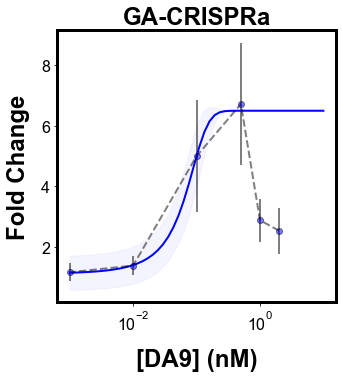

In [105]:
plt.figure(figsize=(5,5))
plt.plot(x_g,y_g,'r-', color = 'blue')
plt.errorbar(x_chimera, GA_FA, GA_FA_err, fmt = 'ko--', mfc = 'blue',alpha = .5)

plt.fill_between(x_g, y_g-err_g, y_g+err_g, color = 'blue', alpha = .045)

plt.xscale('log')
plt.xlabel('[DA9] (nM)', labelpad = xpad, fontsize = 24)
plt.ylabel('Fold Change', labelpad = ypad*1.1, fontsize = 24)
plt.title('GA-CRISPRa', fontsize = 24)

plt.savefig('da9_ga_titrate.svg')

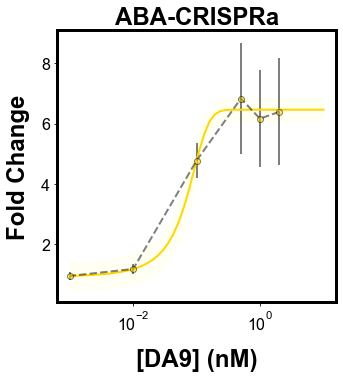

In [106]:
plt.figure(figsize=(5,5))
plt.plot(x_a,y_a,'r-', color = 'gold')
plt.errorbar(x_chimera, ABA_chimera, ABA_chimera_err, fmt = 'ko--',mfc = 'gold', alpha = .5)


plt.fill_between(x_a, y_a-err_a, y_a+err_a, color = 'yellow', alpha = .045)

plt.xscale('log')
plt.xlabel('[DA9] (nM)', labelpad = xpad, fontsize = 24)
plt.ylabel('Fold Change', labelpad = ypad*1.1, fontsize = 24)
plt.title('ABA-CRISPRa', fontsize = 24)

plt.savefig('da9_aba_titrate.svg')

## Figure 5C

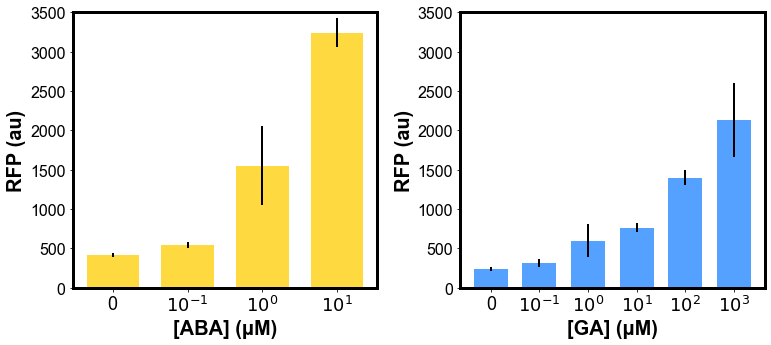

In [95]:
#ABA
rfp_aba = [412.6666667, 545.3333333, 1552, 3241.333333]
xdata_aba = ['0','$10^{-1}$','$10^0$','$10^1$']
err_aba = [28.18391977, 40.99186911, 497.7268327, 187.1692639]

#GA
rfp_ga = [236.6666667,314.6666667,599.3333333,763.6666667,1399.333333,2128.333333]
xdata_ga = ['0','$10^{-1}$','$10^0$','$10^1$','$10^2$', '$10^3$']
err_ga = [28.72861524,50.81666393,206.2530808,53.53814839,97.07900563,473.0394628]

fig, ax = plt.subplots(1, 2, figsize = (11, 5))

ax[0].bar(xdata_aba,rfp_aba, yerr = err_aba,width = .7, color = (1,.85,.25))
ax[0].set_ylabel('RFP (au)', fontsize = 20, weight='bold')
ax[0].set_xlabel('[ABA] (μM)', fontsize = 20, weight='bold')
ax[0].set_xticklabels(xdata_aba, fontsize=18)
ax[0].arrow(10,10,190,190)

ax[1].bar(xdata_ga,rfp_ga, yerr = err_ga, width = .7, color = (.33,.63,1))
ax[1].set_ylabel('RFP (au)', fontsize = 20, weight='bold')
ax[1].set_xticklabels(xdata_ga, fontsize=18)
ax[1].set_xlabel('[GA] (μM)', fontsize = 20, weight='bold')
fig.tight_layout()
ax[0].set_ylim([0,3500])
ax[1].set_ylim([0,3500])

plt.savefig('molecule_titration.svg')

## Figure 6A

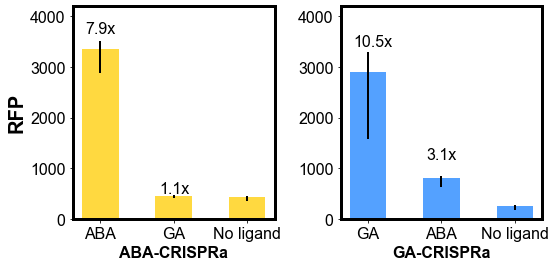

In [109]:
import numpy as np

aba = [[3333,	3365,	3026],
[450,	459,	420],
[422,	435,	381]]

aba_fc = []
for i in range(0,2):
    aba_fc.append(np.average(np.array(aba[i])/np.array(aba[-1])).round(1))

ga = [[2911,	2516,	1969],
[690,681,	798],
[258,204,	248]]

ga_fc = []
for i in range(0,2):
    ga_fc.append(np.average(np.array(ga[i])/np.array(ga[-1])).round(1))

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
aba_labels = ['ABA', 'GA', 'No ligand']
ga_labels = ['GA', 'ABA', 'No ligand']
for i, a in enumerate(aba):
    ax[0].bar(aba_labels[i], a, yerr = np.std(a), width = .5, color = (1,.85,.25))
    if i < 2:
        ax[0].text(i-.2,a[i]*1.1, s = str(aba_fc[i])+'x')
for i, g in enumerate(ga):
    ax[1].bar(ga_labels[i], g, yerr = np.std(g), width = .5, color = (.33,.63,1))    
    if i < 2:
        ax[1].text(i-.2,g[i]+500, s = str(ga_fc[i])+'x')
ax[0].set_ylim(0,4200)
ax[0].set_xlabel('ABA-CRISPRa')
ax[1].set_ylim(0,4200)
ax[1].set_xlabel('GA-CRISPRa')
ax[0].set_ylabel('RFP', fontsize = 20)
plt.tight_layout()

plt.savefig('orthogonal.svg')

## Figure 5B

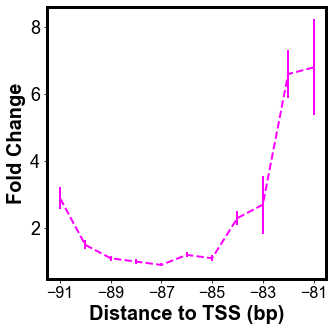

In [113]:
ydata =[[6512,	3914, 5213],			
[4537,	5655,	4698],				
[1109,	2395,	2557],				
[1592,	1671,	1895],				
[794,	907,	810],				
[921,	834,	914],				
[669,	671,	647],				
[771,	739,	666],				
[892,	845,	799],				
[1067,	1177,	1270],				
[1974,	2145,	2529],				
[813,	739,	729]]
xdata = [-81, -82, -83, -84, -85, -86, -87, -88, -89, -90, -91]

fA = []
std = []
for i, s in enumerate(ydata):
    fA.append(np.average(np.array(s)/np.array(ydata[-1])).round(1))
    #std.append(np.std(s))
    std_1 = (np.mean(s)/np.mean(ydata[-1]))*(np.sqrt((np.std(s)/np.mean(s))**2 + (np.std(ydata[-1]/np.mean(ydata[-1]))**2)))

    std.append(std_1)
        
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
#plt.scatter(xdata, fA[:-1], color = 'red')
plt.errorbar(xdata, fA[:-1], yerr = std[:-1], color = 'magenta', linestyle = '--')
#plt.plot(xdata, fA[:-1], color = 'red', linestyle = '--')
plt.ylabel('Fold Change', fontsize = 20, weight = 'bold')
plt.xticks([-81, -83, -85, -87, -89, -91], fontsize = 16)
plt.xlabel('Distance to TSS (bp)', fontsize = 20, weight = 'bold')
plt.yticks(fontsize = 18)

#plt.gca().invert_xaxis()
plt.savefig('synzip_phaseshift.svg')

## Figure 6B

Text(0.5, 1.0, 'AND Gate')

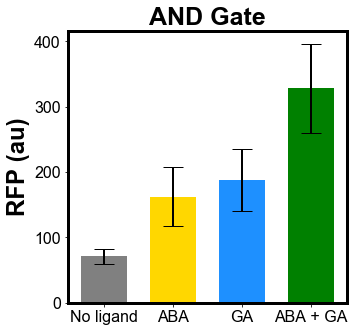

In [160]:
plt.figure(figsize=(5,5))
#x = ['No ligand', 'ABA', 'GA', 'ABA + GA']
RFP = [71, 162,	188, 328.3333333]
Err = [11.34313302, 45.06291898, 47.90963717, 67.76921622]
#plt.bar(x,RFP)
	
x_pos = [.85, 1,1.15, 1.3]

x_labels = ('No ligand', 'ABA', 'GA','ABA + GA')
plt.bar(x_pos[0], RFP[0], yerr = Err[0], width = .1,  capsize = 10, color = 'gray')
plt.bar(x_pos[1], RFP[1], yerr=Err[1], width = .1, capsize = 10, color = 'gold')
plt.bar(x_pos[2], RFP[2], yerr = Err[2], width = .1, capsize = 10, color = 'dodgerblue')
plt.bar(x_pos[3], RFP[3], yerr = Err[3], width = .1, capsize = 10, color = 'green')

plt.xticks(x_pos, x_labels, fontsize = 24)
plt.xticks(rotation = 0, fontsize = 16)

plt.ylabel('RFP (au)', fontsize = 24)

ticklabels = [t for t in plt.gca().get_xticklabels()]
for l in x_labels:
    i = x_labels.index(l)
    #ticklabels[i].set_fontweight("bold")
plt.title('AND Gate')
#plt.savefig('AND_rfp.svg')

In [ ]:
aba = ttest(RFP[0], Err[0], 3, RFP[1], Err[1], 3)
ga = ttest(RFP[0], Err[0], 3, RFP[2], Err[2], 3)
aba_ga = ttest(RFP[1], Err[1], 3, RFP[2], Err[2], 3)
gate_1 = ttest(RFP[1], Err[1], 3, RFP[3], Err[3], 3)
gate_2 = ttest(RFP[2], Err[2], 3, RFP[3], Err[3], 3)

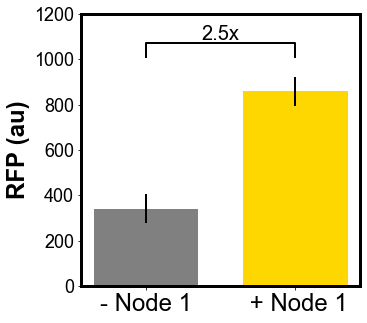

In [121]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

x= np.array([1, 2])
aba = [341, 858.666666666667]
aba_err = [63.0114628019731, 63.679754326717]

ax.bar(x[0], aba[0], yerr=aba_err[0], color = 'gray', width = .7)
ax.bar(x[1], aba[1], yerr=aba_err[1], color = 'gold', width  =.7)
plt.xticks(x, x, fontsize = 20)
plt.ylim(0,1200)



plt.ylabel('RFP (au)', fontsize = 24)
plt.xticks([1,2],['- Node 1', ' + Node 1'], fontsize = 24)
plt.yticks(fontsize = 18)
#plt.xlabel('[DA4.DA9] (nM)')
x_pos = [1,1,2]
y_loc =[950, 950, 950]
#put_pval(1, 2, ttest(aba[0], aba_err[0], 3, aba[1], aba_err[1], 3)[1], x_pos, y_loc, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
#ax.text(1.85,aba[1]*1.15, s = str(2.5)+'x', fontsize = 18)
put_pval(1, 2, '2.5x', x_pos, y_loc, yerr=None, dh=.05, barh=.05, fs=20, maxasterix=None)
plt.savefig('cascade.svg')

## FIgure 3F, S9

In [127]:
file = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/220622-fans_and_cascades.csv'
layout = 'C:/users/rycar/Desktop/UW/Carothers/Plate_Reader/plate_layout_220622.csv' # CSV file with plate layout

plate = pd.read_csv(layout, index_col = 0, dtype = str) # reads plate layout

# need to specify which rows to read for each measurment
RFPEx = pd.read_csv(file, skiprows = 68, nrows = 125,na_values = 'OVRFLW', encoding='ISO-8859-1' ) # reads raw data file at specified rows

RFPEx.index = RFPEx.index*10

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append(str(i[0]) + i[1])
            
exps # print dictionary to check 

{'LH_0': ['A1', 'B1', 'C1'],
 'LH_1': ['A2', 'B2', 'C2'],
 'LH_2': ['A3', 'B3', 'C3'],
 'LH_3': ['A4', 'B4', 'C4'],
 'lowLH_0': ['A5', 'B5', 'C5'],
 'lowLH_1': ['A6', 'B6', 'C6'],
 'highLH_0': ['A7', 'B7', 'C7'],
 'highLH_1': ['A8', 'B8', 'C8'],
 'c_1': ['A9', 'B9', 'C9'],
 'c_0': ['A10', 'B10', 'C10'],
 'blank': ['A11', 'B11', 'C11'],
 '1p_A_pos': ['D1', 'E1', 'F1'],
 '1p_A_neg': ['D2', 'E2', 'F2'],
 '2p_eq_A_pos': ['D3', 'E3', 'F3'],
 '2p_eq_A_neg': ['D4', 'E4', 'F4'],
 '2p_half_A_pos': ['D5', 'E5', 'F5'],
 '2p_half_A_neg': ['D6', 'E6', 'F6'],
 '3p_eq_A_pos': ['D7', 'E7', 'F7'],
 '3p_eq_A_neg': ['D8', 'E8', 'F8'],
 '3p_third_A_pos': ['D9', 'E9', 'F9'],
 '3p_third_A_neg': ['D10', 'E10', 'F10'],
 '4p_eq_A_pos': ['D11', 'E11', 'F11'],
 '4p_eq_A_neg': ['D12', 'E12', 'F12'],
 '4p_fourth_A_pos': ['G1', 'G2', 'G3'],
 '4p_fourth_A_neg': ['G4', 'G5', 'G6'],
 'leak': ['G10', 'G11', 'G12']}

In [129]:
exps['1p_A_pos'] = ['D1','E1']
exps['1p_A_neg'] = ['D2','E2']
#exps['3p_third_A_neg'] = ['E10', 'F10']

A_ep = []
A_dev = []

x = np.linspace(1,14,14)
for a in exps:
    if 'A' in a:
        A_ep.append(np.mean(RFPEx[exps[a]], axis = 1).iloc[-1])
        A_dev.append(np.std(RFPEx[exps[a]], axis =1).iloc[-1])



In [131]:

d = {'Column 1': [A_ep[i] for i in range(0,13,2)],
      'Column 2': [A_ep[i] for i in range(1,14,2)]}

e = {'Column 1': [A_dev[i] for i in range(0,13,2)],
      'Column 2': [A_dev[i] for i in range(1,14,2)]}

df = pd.DataFrame(d)


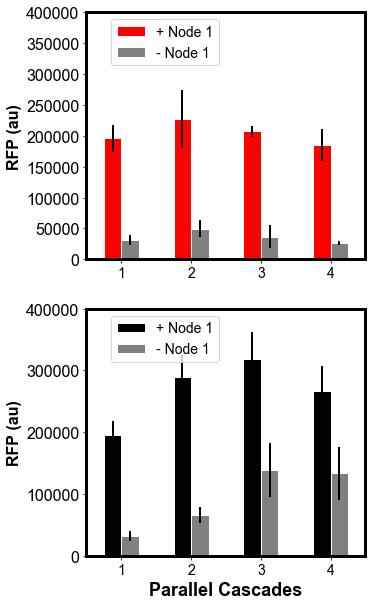

In [132]:
e_df = pd.DataFrame(e)

fig, ax = plt.subplots(2,1, figsize = (5,10))
ax[0].set_yticks([0, 50000,100000, 150000, 200000, 250000, 300000, 350000, 400000])
df.iloc[[0,2,4,6]].plot(kind='bar',edgecolor='white', linewidth=1, yerr = e_df.iloc[[0,2,4,6]].to_numpy().T, color = ['red','gray'], ax = ax[0])
ax[0].set_xticklabels(labels=['1', '2', '3', '4'], fontsize = 14, rotation = 0)
ax[0].legend(labels= ['+ Node 1', '- Node 1'], fontsize = 14,loc='upper right', bbox_to_anchor=(0.5, 1))
df.iloc[[0,1,3,5]].plot(kind='bar',edgecolor='white', linewidth=1, yerr = e_df.iloc[[0,1,3,5]].to_numpy().T, color = ['black','gray'], ax = ax[1])
ax[1].set_xticklabels(labels=['1', '2', '3', '4'], fontsize = 14, rotation  =0)
ax[1].legend(labels= ['+ Node 1', '- Node 1'], fontsize = 14, loc='upper right', bbox_to_anchor=(0.5, 1))

ax[0].set_ylim(0,400000)
ax[1].set_ylim(0,400000)
ax[0].set_ylabel('RFP (au)', fontsize = 16)
ax[1].set_ylabel('RFP (au)', fontsize = 16)
ax[1].set_xlabel('Parallel Cascades', fontsize = 18)


plt.show()

#fig.savefig('fans_raw.svg')

In [133]:
fa = []
fa_err = []

for i in range(0,14,2):
    fa.append(foldActivation(A_ep[i], A_ep[i+1]))
    fa_err.append(foldActivationErr(A_ep[i], A_ep[i+1], A_dev[i], A_dev[i+1]))

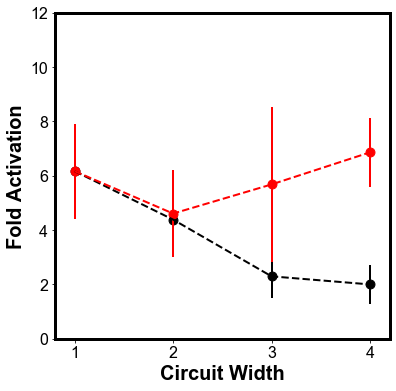

In [134]:
plt.figure(figsize=(6,6))
x = [1, 2, 3, 4]
split = [fa[i] for i in range(0,7,2)]
split_err = [fa_err[i] for i in range(0,7,2)]
eq = [fa[i] for i in range(1, 7, 2)] 
eq = np.insert(eq, 0, fa[0])
eq_err = [fa_err[i] for i in range(1, 7, 2)]
eq_err = np.insert(eq_err, 0, fa_err[0])

plt.errorbar(x, eq, yerr = eq_err,  color = 'black', linestyle = '--')
plt.errorbar(x, split, yerr=split_err,  color = 'red', linestyle = '--')
plt.scatter(x, eq,  color = 'black', marker=  'o', s = 80)
plt.scatter(x, split, color = 'red', s= 80)

plt.ylim(0,12)
plt.xticks([1, 2, 3, 4], fontsize = 16)
plt.ylabel('Fold Activation', fontsize = 20)
plt.xlabel('Circuit Width', fontsize = 20)

plt.savefig('wide_FA.png')


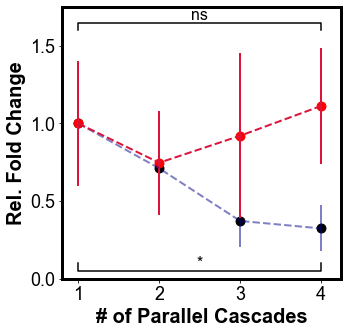

In [136]:
eq_norm = [i/eq[0] for i in eq]
split_norm = [i/split[0] for i in split]

eq_err_norm = [foldActivationErr(eq[i], eq[0], eq_err[i], eq_err[0]) for i in range(0,4)]
split_err_norm = [foldActivationErr(split[i], split[0], split_err[i], split_err[0]) for i in range(0,4)]

plt.figure(figsize=(5,5))

x_fake = [.8,2.2,3.2,4.2]
plt.errorbar(x, eq_norm, yerr = eq_err_norm,  color = 'darkblue', linestyle = '--', alpha = .5)
#plt.plot(x_eq,y_eq, color = 'blue')
#plt.fill_between(x_eq,y_eq-yerr_eq,y_eq+yerr_eq, color = 'blue', alpha = .045)


plt.errorbar(x, split_norm, yerr=split_err_norm,  color = 'crimson', linestyle = '--')
#plt.plot(x_split,y_split, color = 'red')
#plt.fill_between(x_split,y_split-yerr_split,y_split+yerr_split, color = 'red', alpha = .045)

plt.scatter(x, eq_norm,  color = 'black', marker=  'o', s = 80)
plt.scatter(x, split_norm, color = 'red', s= 80)

plt.ylim(0,1.75)
plt.xlim(.8,4.25)
plt.xticks([1, 2, 3, 4], fontsize = 18)
plt.yticks([0,.5,1,1.5], fontsize = 18)
plt.ylabel('Rel. Fold Change', fontsize = 20, weight = 'bold')
plt.xlabel('# of Parallel Cascades', fontsize = 20)

#plt.text(3.98, 1.5, '*', fontsize = 'x-large')

x1, x2 = 1, 4  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 1.6, .05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col, fontsize = 16)

x1, x2 = 1, 4  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = .1, -.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize = 16)

plt.savefig('fans_FA.svg')

In [137]:
import lmfit as lmf

x_fit = sum([[c,c,c] for c in x],[])
y_fit = sum([[y, y+e, y-e] for y,e in zip(eq_norm, eq_err_norm)],[])
step_mod = lmf.models.PowerLawModel()
pars = step_mod.guess(y_fit, x_fit)
mod = step_mod
out = mod.fit(y_fit, pars, x=x_fit, max_nfev = 500)
x_eq = np.linspace(1,4)
y_eq = out.eval(x=xnew)
yerr_eq = out.eval_uncertainty(x=x_eq)


In [138]:

x_fit = sum([[c,c,c] for c in x],[])
y_fit = sum([[y, y+e, y-e] for y,e in zip(split_norm, split_err_norm)],[])
step_mod = lmf.models.LinearModel()
pars = step_mod.guess(y_fit, x_fit)
mod = step_mod
out = mod.fit(y_fit, pars, x=x_fit, max_nfev = 500)
x_split = np.linspace(0,4)
y_split = out.eval(x=xnew)
yerr_split = out.eval_uncertainty(x=x_split)


## Figure 5D

In [139]:
'''
GA_FA =[0.731651376146789,
 0.9701834862385322,
 2.341743119266055,
 1.2201834862385321,
 1.0779816513761467,
 1.1467889908256879,
 5.928899082568806,
 1.0756880733944953,
 2.0573394495412844,
 2.120412844036697,
 5.8577981651376145,
 1.0229357798165137,
 1.6364678899082568,
 1.8704128440366974,
 4.446100917431193,
 1.3841743119266054,
 1.0]
'''

GA_FA = [ 1.2201834862385321,
 1.0756880733944953,
 1.0229357798165137,
 1.3841743119266054,
 2.341743119266055,
 5.928899082568806,
 5.8577981651376145,
 4.446100917431193,
 0.9701834862385322,
 1.1467889908256879,
 2.120412844036697,
 1.8704128440366974,
0.731651376146789,
 1.0779816513761467,
 2.0573394495412844,
 1.6364678899082568]

'''
GA_Err = [0.09697793536955883,
 0.26013664130693487,
 0.3179518734952659,
 0.22145779355345005,
 0.1076269335110302,
 0.18226659021835734,
 0.5820036333067631,
 0.11136666825662583,
 0.5573090005149219,
 0.33937048950715154,
 1.0758267961539776,
 0.13021413761435136,
 0.1873118703263905,
 0.4497413187156039,
 0.5593186607547487,
 0.1556510797615432,
 0.12482628279071353]
'''

GA_Err = [ 0.22145779355345005,
 0.11136666825662583,
 0.13021413761435136,
 0.1556510797615432,
 0.3179518734952659,
 0.5820036333067631,
 1.0758267961539776,
 0.5593186607547487,
 0.26013664130693487,
 0.18226659021835734,
 0.33937048950715154,
 0.4497413187156039,
0.09697793536955883,
0.1076269335110302,
 0.5573090005149219,
 0.4497413187156039]


'''
ABA_FA = [4.845808383233533,
 4.754491017964072,
 7.761976047904191,
 2.122754491017964,
 3.55688622754491,
 12.832335329341316,
 13.519461077844309,
 2.947604790419161,
 2.2649700598802394,
 18.585329341317365,
 12.6751497005988,
 2.9970059880239517,
 6.440119760479042,
 14.535928143712573,
 8.949101796407184,
 4.570359281437126,
 1.0]    
'''

ABA_FA = [ 2.122754491017964,
 2.947604790419161,
 2.9970059880239517,
 4.570359281437126,
 7.761976047904191,
 13.519461077844309,
 12.6751497005988,
 8.949101796407184,
 4.754491017964072,
 12.832335329341316,
 18.585329341317365,
 14.535928143712573,
 4.845808383233533,
 3.55688622754491,
 2.2649700598802394,
 6.440119760479042]

'''
ABA_Err = [1.6305021051903839,
 0.1703867086177884,
 1.9783020678259469,
 0.15005687815637417,
 0.4974188269431505,
 0.6335535950266062,
 0.6577719363870412,
 0.1950894489110807,
 0.6412384291795363,
 2.7290401649859466,
 0.8758743476570816,
 0.396022787155085,
 0.6632010895230949,
 0.5163949274964216,
 0.774470961721447,
 0.15734655319208993,
 0.0349158796098521]
'''
ABA_Err = [ 0.15005687815637417,
 0.1950894489110807,
 0.396022787155085,
 0.15734655319208993,
 1.9783020678259469,
 0.6577719363870412,
 0.8758743476570816,
 0.774470961721447,
 0.1703867086177884,
 0.6335535950266062,
 2.7290401649859466,
 0.5163949274964216,
 1.6305021051903839,
 0.4974188269431505,
 0.6412384291795363,
 0.6632010895230949,
]

SYNZIP_FA =[59.18673883626525,
 38.68200270635996,
 22.25439783491205,
 6.189445196211098,
 18.867388362652235,
 66.98917456021653,
 51.17726657645469,
 49.31935047361301,
 10.401894451962113,
 34.36129905277403,
 29.684709066305828,
 24.14073071718539,
 5.787550744248987,
 10.879566982408663,
 32.97023004059541,
 57.30852503382952,
 1.0]

SYNZIP_Err = [8.15958794617842,
 5.33297576299188,
 3.7500638828847253,
 1.16184420081329,
 4.639241231159957,
 17.394724651534123,
 8.363074065449597,
 11.742433012832208,
 2.385980045866987,
 7.137645471614383,
 4.150117107235026,
 4.033381407030832,
 0.8488547550543927,
 2.0213803292395043,
 4.609717127555072,
 8.19313493517055,
 0.1948203241441428]

In [141]:
'''
FA_2D = [
[59.1867388362652, 38.68200270636, 22.2543978349121, 6.1894451962111],
[18.8673883626522, 66.9891745602165, 51.1772665764547, 49.319350473613],
[10.4018944519621, 34.361299052774, 25.7198917456022, 24.1407307171854],
[5.78755074424899, 10.8795669824087, 32.9702300405954, 57.3085250338295]
]
'''

FA_2D = []
Err_2D = []
FA_temp = []
Err_temp = []
for i,x in enumerate(SYNZIP_FA,1):
    FA_temp.append(x)
    if i%4 == 0:
        FA_2D.append(FA_temp)
        FA_temp = []
for i,x in enumerate(SYNZIP_Err,1):
    Err_temp.append(x)
    if i%4 == 0:
        Err_2D.append(Err_temp)
        Err_temp = []



In [142]:
FA_2D = list(reversed(FA_2D))
Err_2D = list(reversed(Err_2D))

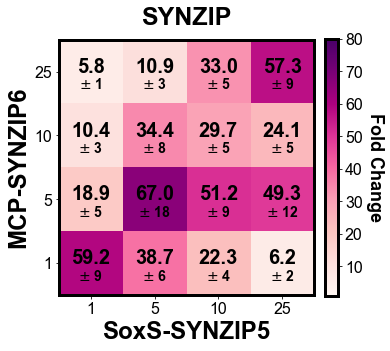

In [143]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'RdPu', vmin = 1, vmax = 80)
xlabels = ['1','5','10','25']
plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('Fold Change', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 20)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 14)
plt.ylabel('MCP-SYNZIP6', size = 24)
plt.xlabel('SoxS-SYNZIP5', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
plt.yticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.title('SYNZIP', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

plt.savefig('szp_heatmap.svg')

In [144]:
FA_2D = []
Err_2D = []
FA_temp = []
Err_temp = []
for i,x in enumerate(ABA_FA,1):
    FA_temp.append(x)
    if i%4 == 0:
        FA_2D.append(FA_temp)
        FA_temp = []
for i,x in enumerate(ABA_Err,1):
    Err_temp.append(x)
    if i%4 == 0:
        Err_2D.append(Err_temp)
        Err_temp = []
        
#for i,x in enumerate(FA_2D):
#    FA_2D[i] = list(reversed(x))
#    Err_2D[i] = list(reversed(Err_2D[i]))
#FA_2D = list(reversed(FA_2D))
#Err_2D = list(reversed(Err_2D))

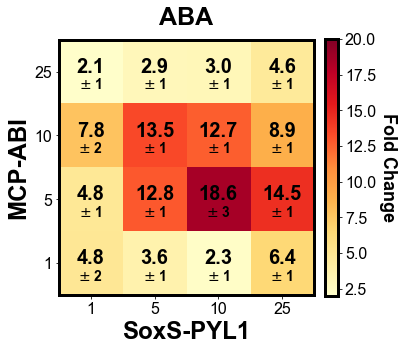

In [145]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'YlOrRd', vmin = 2, vmax = 20)
xlabels = ['1','5','10','25']
plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('Fold Change', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 20)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 14)
plt.ylabel('MCP-ABI', size = 24)
plt.xlabel('SoxS-PYL1', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
plt.yticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.title('ABA', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

plt.savefig('aba_heatmap.svg')

In [146]:
FA_2D = []
Err_2D = []
FA_temp = []
Err_temp = []
for i,x in enumerate(GA_FA,1):
    FA_temp.append(x)
    if i%4 == 0:
        FA_2D.append(FA_temp)
        FA_temp = []
for i,x in enumerate(GA_Err,1):
    Err_temp.append(x)
    if i%4 == 0:
        Err_2D.append(Err_temp)
        Err_temp = []

#FA_2D = list(reversed(FA_2D))
#Err_2D = list(reversed(Err_2D))

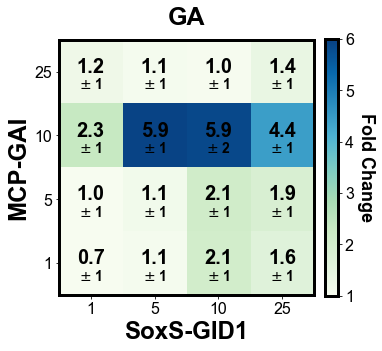

In [147]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'GnBu', vmin = 1, vmax = 6)
xlabels = ['1','5','10','25']
plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('Fold Change', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 20)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 14)
plt.ylabel('MCP-GAI', size = 24)
plt.xlabel('SoxS-GID1', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
plt.yticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.title('GA', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

plt.savefig('ga_heatmap.svg')

## Figure S4: Combinatorial promoter assembly

In [148]:
promoter_FA = [
194.4902188,	199.9445679,	399.1933387,	47.97800077,	
228.1047163,	236.4691925,	269.0547205,	84.49275759,	
177.4512849,	170.677365,	303.1922223,	65.03802218,	
192.6467706,	155.0507581,	205.6296537,	67.56209857]

promoter_err = [
33.84728936,	16.12909602,	94.94420759,	0.600263868,
4.406779423,	24.67585905,	9.194229197,	3.552926618,
10.15001021,	21.71830581,	16.52071631,	2.592552575,
10.27796154,	5.459053797,	21.76143573,	5.783544203]


In [149]:
FA_2D = []
Err_2D = []
FA_temp = []
Err_temp = []
for i,x in enumerate(promoter_FA,1):
    FA_temp.append(x)
    if i%4 == 0:
        FA_2D.append(FA_temp)
        FA_temp = []
for i,x in enumerate(promoter_err,1):
    Err_temp.append(x)
    if i%4 == 0:
        Err_2D.append(Err_temp)
        Err_temp = []

#FA_2D = list(reversed(FA_2D))
#Err_2D = list(reversed(Err_2D))
FA_2D = np.array(FA_2D).T

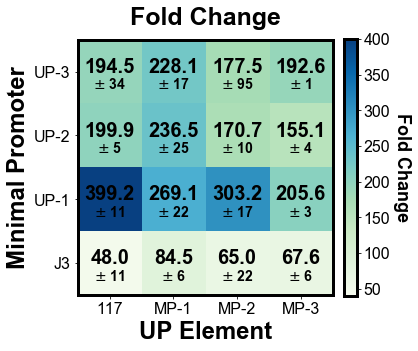

In [150]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'GnBu', vmin = 40, vmax = 400)
xlabels = ['117','MP-1','MP-2','MP-3']
ylabels = ['J3','UP-1','UP-2','UP-3']

plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('Fold Change', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 20)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 14)
plt.ylabel('Minimal Promoter', size = 24)
plt.xlabel('UP Element', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
#plt.xticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.yticks(ticks = [3, 2, 1, 0],labels = ylabels, fontsize = 16)

plt.title('Fold Change', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

plt.savefig('promoter_FA_heatmap.svg')

In [151]:
promoter_on = [
8866.06792,	12478.45291,	12720.78047,	10148.40347,
12560.06105,	15257.66438,	14005.11252,	12859.02221,
6605.683973,	8032.089934,	7383.395425,	7032.883993,
7184.577871,	8991.727876,	8436.86537,	7351.691556
]

promoter_on_err = [
1525.141311,	292.1740948,	3020.783426,	75.24192104,
150.3659938,	904.3623391,	189.2588738,	280.8407311,
310.2936509,	558.6908255,	225.0250541,	277.594126,
67.81333073,	205.8784366,	642.9317042,	506.8833885
]

promoter_off = [
45.58618925,	62.40956202,	31.86621429,	211.5220166,
55.06269777,	64.52284217,	52.05302661,	152.1908218,
37.22533752,	47.06007697,	24.35219271,	108.134961,
37.29404779,	57.99215678,	41.02941972,	108.8138425
]

promoter_off_err = [
1.202498344,	4.817707422,	0.423592102,	2.131666498,
0.834894571,	5.541433445,	1.633779064,	5.468765154,
1.214925258,	5.014440303,	1.099959143,	0.602430247,
1.958301445,	1.55108048,	3.012917216,	5.520768727
]

In [156]:
FA_2D = []
Err_2D = []
FA_temp = []
Err_temp = []
for i,x in enumerate(promoter_on,1):
    FA_temp.append(x)
    if i%4 == 0:
        FA_2D.append(FA_temp)
        FA_temp = []
for i,x in enumerate(promoter_on_err,1):
    Err_temp.append(x)
    if i%4 == 0:
        Err_2D.append(Err_temp)
        Err_temp = []

#FA_2D = list(reversed(FA_2D))
#Err_2D = list(reversed(Err_2D))
FA_2D = np.array(FA_2D).T

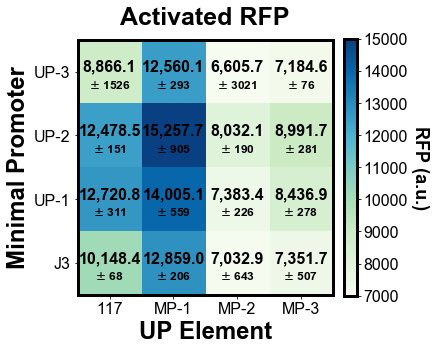

In [157]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'GnBu', vmin = 7000, vmax = 15000)
xlabels = ['117','MP-1','MP-2','MP-3']
ylabels = ['J3','UP-1','UP-2','UP-3']

plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('RFP (a.u.)', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 16)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 12)
plt.ylabel('Minimal Promoter', size = 24)
plt.xlabel('UP Element', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
#plt.xticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.yticks(ticks = [3, 2, 1, 0],labels = ylabels, fontsize = 16)

plt.title('Activated RFP', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

#plt.savefig('promoter_on_heatmap.svg')

In [158]:
FA_2D = []
Err_2D = []
FA_temp = []
Err_temp = []
for i,x in enumerate(promoter_off,1):
    FA_temp.append(x)
    if i%4 == 0:
        FA_2D.append(FA_temp)
        FA_temp = []
for i,x in enumerate(promoter_off_err,1):
    Err_temp.append(x)
    if i%4 == 0:
        Err_2D.append(Err_temp)
        Err_temp = []

#FA_2D = list(reversed(FA_2D))
#Err_2D = list(reversed(Err_2D))
FA_2D = np.array(FA_2D).T

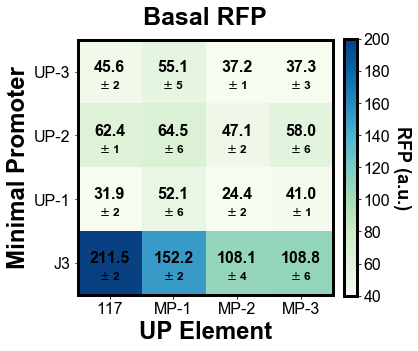

In [159]:
plt.figure(figsize=(5,5))
plt.imshow(FA_2D,cmap = 'GnBu', vmin = 40, vmax = 200)
xlabels = ['117','MP-1','MP-2','MP-3']
ylabels = ['J3','UP-1','UP-2','UP-3']

plt.colorbar(fraction=0.046, pad=0.04).ax.set_ylabel('RFP (a.u.)', rotation=270, labelpad = ypad*2.1, size = 18)
for i in range(4):
    for j in range(4):
        plt.text(j, i-0.075, '{:,.01f}'.format(FA_2D[i][j]),ha="center", va="center", color = 'black', fontweight ='bold', size = 16)
        plt.text(j, i+0.2, '$\pm$ %.0f' % np.ceil(Err_2D[i][j]),ha='center',va='center', color = 'black',fontweight ='bold', size = 12)
plt.ylabel('Minimal Promoter', size = 24)
plt.xlabel('UP Element', size = 24)
plt.xticks(ticks = [0, 1, 2, 3],labels = xlabels, fontsize = 16)
#plt.xticks(ticks = [3, 2, 1, 0],labels = xlabels, fontsize = 16)

plt.yticks(ticks = [3, 2, 1, 0],labels = ylabels, fontsize = 16)

plt.title('Basal RFP', pad = xpad)

plt.subplots_adjust(hspace = 0, wspace = 0.75)

plt.savefig('promoter_off_heatmap.svg')